# Convolutional Neural Networks (LeNet)

Following: http://deeplearning.net/tutorial/lenet.html

## Motivation

Convolutional Neural Networks (CNN) are biologically-inspired variants of MLPs. From [Hubel68](http://deeplearning.net/tutorial/references.html#hubel68), we know the visual cortex contains a complex arrangement of cells. They are sensitive to small sub-regions of the visual field, called a _receptive field_. The sub-regions are tiled to cover the entire visual field. These cells act as local filters over the input space and are able to exploit the strong spatially local correlation present in natural images.

Furthermore, two basic cell types have been identified: simple cells respond maximally to specific edge-like patterns, and complex, larger cells with larger receptive fields are locally invariant to the exact position of the pattern.

Because the animal visual cortex is the most powerful visual processing system we know of, it seems natural to attempt to simulate its behavior. LeNet-5 [LeCun98](http://deeplearning.net/tutorial/references.html#lecun98) is the focus of this tutorial.

## Sparse Connectivity

CNNs exploit spatially-local correlation by enforcing a local connectivity pattern between neurons of adjacent layers. In other words, the inputs of hidden layer `m` are a subset of the units in layer `m-1`, units with spatially contiguous receptive fields.

<img src="sparse_1D_nn.png">

Here layer `m-1` is an "input retina." Units in layer `m` have receptive field widths of 3, and units in layer `m+1` have a similar connectivity to the layer below. We say `m+1` has receptive field width with respect to `m` of 3, but of 5 with respect to `m-1`. Each unit is clearly not receptive to variations outside its receptive field - this architecture ensures the learned "filters" produce the strongest response to a spatially local input pattern.

Stacking many such layers leads to (non-linear) "filters" that become increasingly "global" (responsive to a larger pixel space). Here, for example, layer `m+1` can encode a non-linear feature of width 5.

## Shared Weights

Additionally, in CNNs, each filter $h_i$ is replicated across the entire visual field. These replicated units share the same parameterization (weights and biases) and are called a _feature map_.

<img src="conv_1D_nn.png">

Here we show 3 hiddend units belonging to the same feature map. Weights of the same color are shared - i.e., constrained to be identical. Gradient descent can still be used to learn such shared parameters - the gradient of a shared weight is simple the sum of the gradients of the parameters being shared.

By replicating units like this, we create feature detection that operates independent of location in the visual field. The weight-sharing also increases learning efficiency by reducing the number of features being learned. These constraints allow CNNs to achieve generalization on vision problems.

## Details and Notation

A feature map is obtained by repeated application of a function across sub-regions of the entire image, i.e. by _convolution_ of the input image with a linear filter, adding a bias term and then applying a non-linear function. We denote the $k$th feature map at a given layer as $h^k$, with filters for that map determined by weights $W^k$ and bias $b_k$. The feature map is then obtained as follows (assuming $tanh$ for non-linearities):

\begin{equation}
h_{ij}^k = \text{tanh}\left((W^k * x)_{ij} + b_k \right)
\end{equation}

**Note:** Recall the definition of convolution for a 1D signal:

\begin{equation}
o[n] = f[n] * g[n] = \sum_{u=-\infty}^{\infty} f[u]g[n - u] = \sum_{u=-\infty}^{\infty} f[n - u]g[u]
\end{equation}

This may be extended to 2D as follows:

\begin{equation}
o[m, n] = f[m, n] * g[m, n] = \sum_{u=-\infty}^{\infty} \sum_{v=-\infty}^{\infty} f[u, v]g[m - u, n - v]
\end{equation}

To form a richer representation of the data, each hidden layer is composed of _multiple_ feature maps, $\left\{h^{(k)}, k = 0 \dots K\right\}$. The weights $W$ of a hidden layer may be represented as a 4D tensor containing elements for every combination of destination feature map, source feature map, source vertical position, and source horizontal position. The biases, $b$, may be represented as a vector with one element for each destination feature map.

<img src="cnn_explained.png">

Here we visualize two layers of a CNN. Layer `m-1` contains four feature maps, shown here as a repetition of the raw pixel layer four times. Hidden layer `m` contains two feature maps, $h^0$ and $h^1$, shown here as a repetion of the raw pixel layer twice (we should say $h^1$ and $h^2$ to better correspond to the index notation in the figure, or change the index notation in the figure to use $w^0$ and $w^1$ so the correspondence is clearer, but, oh well). Pixels (neuron outputs) in each of the feature maps $h^0$ and $h^1$ are computed using pixels of layer `m-1` that fall within their $2 \times 2$ receptive field. Note that the receptive field spans all four input feature maps, with the different colors mapped each to one of the representations of the pixel layer. Weights $W^0$ and $W^1$ of $h^0$ and $h^1$ are therefore 3D tensors. The leading dimension (upper r.h.s.) indexes the input feature maps, while the other two index pixel coordinates.

Therefore, $W_{ij}^{kl}$ denotes the weight connecting each pixel of the $k$th feature map at layer `m`, with pixel coordinates $(i,j)$ of the $l$th feature map of layer `m-1`. (Does this fit with the figure and the preceeding paragraph? - The preceeding paragraph seems to explain $W_{ij}^{0k}$ and how $l$ fits with the description is not obvious. The two seem to be somewhat inconsistent, but the latter does provide a way to think about indexing that is useful even if it isn't accurately represented in the figure.)

**Note:** The notation is very confusing here since we seem to be using different conventions for the weight tensors in `m-1` and `m`. Also, it isn't totally clear if $w^{i}_{\text{blue}}$ and $w^{i}_{\text{red}}$ in the figure view the same pixels in `m-1`, but I suspect they do.

## The Convolution Operator

`ConvOp` is the main workhorse for implementing a convolutional layer in Theano. It is used by `theano.tensor.signal.conv2d`, which takes two symbolic inputs:

* a 4D tensor corresponding to a mini-batch of input images; the shape is [mini-batch size, number of input feature maps, image height, image width],
* a 4D tensor corresponding to the weight matrix $W$; the shape is [number of feature maps at layer `m`, number of feature maps at layer `m-1`, filter height, filter width]

In [1]:
%matplotlib inline

In [2]:
cat three_wolf.py

#!/usr/bin/env python
"""
This is Theano code for implementing a convolutional layer. The input consists
of 3 feature maps (an RGB color image) of size 120x160. We use convolutional
filters with 9x9 receptive fields.

Following:
    http://deeplearning.net/tutorial/lenet.html
"""

import theano
from theano import tensor as T
from theano.tensor.nnet import conv

import numpy
import pylab
from PIL import Image

rng = numpy.random.RandomState(23455)

# 4D tensor for input
input = T.tensor4(name='input')

# shared variable for weights
w_shp = (2, 3, 9, 9)
w_bound = numpy.sqrt(3 * 9 * 9)
W = theano.shared(
    numpy.asarray(
        rng.uniform(
            low=-1.0 / w_bound,
            high=1.0 / w_bound,
            size=w_shp
        ),
        dtype=input.dtype
    ),
    name='W'
)

# initialize shared variables for bias with random values
# NOTE: biases are typically initialized to zero - however, here we simply
# apply the convolutional layer to an image without learning its parame

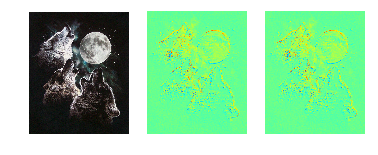

In [4]:
run three_wolf.py

Notice that a randomly initialized filter acts very much like an edge detector! Note also that we used the same weight initialization formul as with the MLP. Weights are sampled from a uniform distribution over the range `[-1/fan-in, 1/fan-in]` where `fan-in` is the number of inputs to a hidden unit. For MLPs, this is the number of units in the layer below. For a CNN, however, we must also consider the number of input feature maps and the size of the receptive fields.

## MaxPooling